# Group Project 2024/25





### Task



Allenare un AE per Anomaly Detection in grado di riconoscere segnali prodotti da jeti adronici anomali in un reivelatore di fisica delle alte energie.

Alle energie estreme del Large Hadron Collider, particelle massive possono essere prodotte con un tale boost di Lorentz da far sì che i loro decadimenti in adroni (getti adronici) risultino così collimati che le particelle prodotte si sovrappongono. Determinare se la sottostruttura di un getto osservato sia dovuta a una singola particella di bassa massa oppure a molteplici prodotti di decadimento di una particella di massa elevata è un problema cruciale nell’analisi dei dati del LHC. Gli approcci tradizionali si basano su osservabili di alto livello costruite a partire da modelli teorici di deposizione di energia nei calorimetri e da parametri delle tracce cariche ricostruite nel tracciatore interno, ma la complessità dei dati rende questo compito un candidato ideale per l’applicazione di strumenti di deep learning. I costituenti dei getti possono infatti essere rappresentati come immagini 2D in cui ogni pixel rappresenta una delle celle sensibili del calorimetro, e il contenuto della cella una misura dell'energia o della quantità di moto depositata nella cella.

**Dataset:**

I dati del progetto sono nella forma di immagini 2D di dimensione (100,100), ogni cella rappresenta l'energia depositata in quella cella dalle particelle del jet adronico corrispondente. Ci sono due tipologie di jet adronici consider ati: *jet normali*, costituiti dalla adronizzazione di un quark leggero o gluone, e *jet anomali* (disponibili in una frazione incognita solo nel test set) costituiti dall'adronizzazione dei quark nel decadimento $t \to Wb \to qq'b$, in cui a causa del boost del quark top, i tre quark nello stato finale sono parzialmente sovrapposti.

* *Normal data dataset:* 12k jet rappresentati come histogrammi 2D della quantità di moto depositata in ciascuno dei 100x100 bin di una finestra quadrata nel piano ($\theta,\phi$) centrato intorno all'asse del jet.

* *Test dataset:*
due dataset costituiti ciascuno da 3k eventi, contenenti jet normali e jet anomali in una frazione relativa icognita da determinare. Nel primo dataset (*_high*) la frazione incognita di eventi anomali è $\ge 55\%$. Nel secondo dataset (*_low*) la frazione incognita di eventi anomali incognita è $\le 45\%$.
Potete utilizzare questa informazione per verificare che le vostre predizioni soddisfino la relazione $f_{high} > f_{low}$.

I dati sono forniti come array numpy in un file numpy compresso (.npz), leggibile con l'esempio di codice che segue:


```
import numpy as np

f_train = np.load('Normal_data.npz')
f_test_l = np.load('Test_data_low.npz')
f_test_h = np.load('Test_data_high.npz')

normal_data = f_train['normal_data']
test_data_l = f_test_l['test_data']
test_data_h = f_test_h['test_data']

print(normal_data.shape)
print(test_data_l.shape)
print(test_data_h.shape)
```

**Per scaricare i dataset:**
* dati normali:
```
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/Normal_data.npz
```
* dati anomali:
```
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/<Identificativo Dataset>/Test_data_low.npz
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/<Identificativo Dataset>/Test_data_high.npz
```
```
# <Identificativo Dataset> dal foglio excel prenotazione gruppi
```


**Obiettivi minimi del progetto (potete a vostro piacimento aggiungere ulteriori analisi/studi:**

1. Plot della rappresentazione latente delle immagini di test fatto con riduzione dimensionale.
2. Stima della frazione di eventi anomali presente nei due Test dataset, tenendo conto che la di procedura di stima deve garantire che la rate di falsi postivi sia inferiore a circa il $10\%$ (FPR $\le \sim 10\%$).
3. Clustering dello spazio (per esempio usando un algoritmo GMM).
4. Misura della purezza dei cluster rispetto alle label assegnate in anomaly score.


**Nota Importante:**

Il notebook deve essere compilato come una relazione scientifica del progetto, quindi deve contenere sia il codice (leggibile e riproducibile), i risultati in termini di grafici e tabelle numeriche, e il testo che illustra la strategia ottenuta, le scelte compiute, e i risultati ottenuti.

## Codice

In [42]:
#@title Importazione librerie, settaggio seed per la riproducibilità
!pip install -q pytorch-lightning

import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# Impostazioni per la riproducibilità
SEED = 42
pl.seed_everything(SEED, workers=True)

# Device (CPU/GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {DEVICE} device")

# Download dei dataset
ID = "G15"
!wget -nc http://giagu.web.cern.ch/giagu/CERN/P2025/Normal_data.npz
!wget -nc http://giagu.web.cern.ch/giagu/CERN/P2025/{ID}/Test_data_low.npz
!wget -nc http://giagu.web.cern.ch/giagu/CERN/P2025/{ID}/Test_data_high.npz

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using cuda device
File ‘Normal_data.npz’ already there; not retrieving.

File ‘Test_data_low.npz’ already there; not retrieving.

File ‘Test_data_high.npz’ already there; not retrieving.



### Caricamento dei Dataset/Dataloader e visualizzazione preliminare

In [43]:
#@title Creazione Datasets e DataLoader PyTorch

f_train = np.load('Normal_data.npz')
f_test_l = np.load('Test_data_low.npz')
f_test_h = np.load('Test_data_high.npz')

normal_data = f_train['normal_data']
test_data_l = f_test_l['test_data']
test_data_h = f_test_h['test_data']

# Normalizzazione [0,1] usando solo il training set
train_min = np.min(normal_data)
train_max = np.max(normal_data)

def normalize(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min + 1e-8)

normal_data = normalize(normal_data, train_min, train_max)
test_data_l = normalize(test_data_l, train_min, train_max)
test_data_h = normalize(test_data_h, train_min, train_max)

# Conversione in tensori torch
normal_tensor = torch.tensor(normal_data, dtype=torch.float32).unsqueeze(1)
test_tensor_l = torch.tensor(test_data_l, dtype=torch.float32).unsqueeze(1)
test_tensor_h = torch.tensor(test_data_h, dtype=torch.float32).unsqueeze(1)

# Test datasets
train_dataset = TensorDataset(normal_tensor)
test_dataset_l = TensorDataset(test_tensor_l)
test_dataset_h = TensorDataset(test_tensor_h)

# DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader_l = DataLoader(test_dataset_l, batch_size=BATCH_SIZE, shuffle=False)
test_loader_h = DataLoader(test_dataset_h, batch_size=BATCH_SIZE, shuffle=False)

# Info
print(f"Train: {len(train_dataset)} | Test Low: {len(test_dataset_l)} | Test High: {len(test_dataset_h)}")

datasets = {
    "Train (Normal)": normal_data,
    "Test Low": test_data_l,
    "Test High": test_data_h
}
print("\nLa normalizzazione tra 0 e 1 è basata sui dati di training:")
for name, data in datasets.items():
    print(f"{name}: min = {np.min(data):.4f}, max = {np.max(data):.4f}")


Train: 12000 | Test Low: 3000 | Test High: 3000

La normalizzazione tra 0 e 1 è basata sui dati di training:
Train (Normal): min = 0.0000, max = 1.0000
Test Low: min = 0.0000, max = 0.9012
Test High: min = 0.0000, max = 0.9624


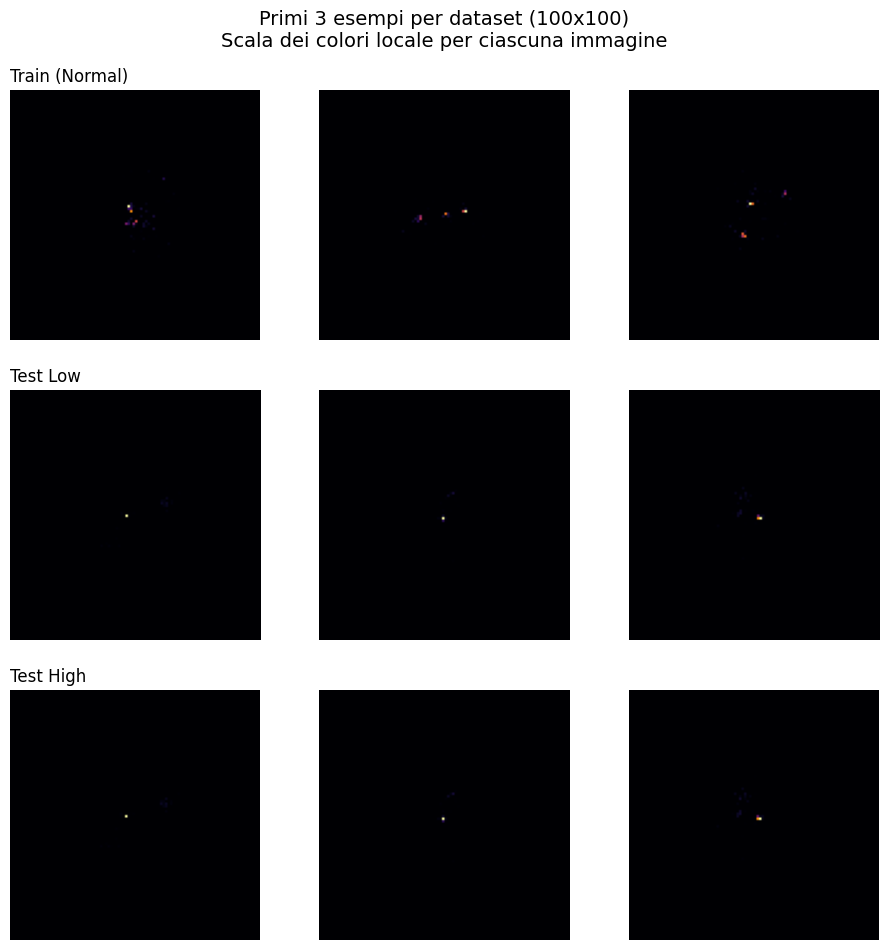

In [44]:
#@title plot di alcuni eventi del dataset

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.suptitle("Primi 3 esempi per dataset (100x100)\nScala dei colori locale per ciascuna immagine", fontsize=14)

for row_idx, (label, data) in enumerate(datasets.items()):
    for col_idx in range(3):
        ax = axes[row_idx, col_idx]
        img = data[col_idx]
        im = ax.imshow(img, cmap="inferno", origin="lower", vmin=np.min(img), vmax=np.max(img))
        ax.axis("off")
        if col_idx == 0:
            ax.set_title(label, fontsize=12, loc='left')

fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1, hspace=0.2)
plt.show()

### Definizione del Modello e dei Parametri


In [50]:
#@title Modello ConvAE

class ConvAE(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters(config)
        self.lr = config.get("lr", 1e-3)
        self.dropout = config.get("dropout", 0.0)
        hidden_dim = config["hidden_dim"]

        # Encoder
        in_channels = 1
        encoder_layers = []
        for conv in config["in_conv"]:
            encoder_layers.append(nn.Conv2d(in_channels, **{k: v for k, v in conv.items() if k != "output_padding"}))
            encoder_layers.append(nn.ReLU())
            if self.dropout > 0:
                encoder_layers.append(nn.Dropout2d(self.dropout))
            in_channels = conv["out_channels"]
        self.encoder_conv = nn.Sequential(*encoder_layers)

        # Calcola shape del bottleneck convoluzionale
        dummy_input = torch.zeros(1, 1, 100, 100)
        with torch.no_grad():
            dummy_out = self.encoder_conv(dummy_input)
            self.conv_shape = dummy_out.shape[1:]  # (C, H, W)
            self.flat_dim = dummy_out.numel()

        # Bottleneck FC
        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_dim, hidden_dim)
        )
        self.decoder_fc = nn.Sequential(
            nn.Linear(hidden_dim, self.flat_dim),
            nn.ReLU()
        )

        # Decoder
        decoder_layers = []
        in_channels = config["in_conv"][-1]["out_channels"]
        for conv in config["out_conv"]:
            decoder_layers.append(nn.ConvTranspose2d(in_channels, **conv))
            decoder_layers.append(nn.ReLU())
            if self.dropout > 0:
                decoder_layers.append(nn.Dropout2d(self.dropout))
            in_channels = conv["out_channels"]
        decoder_layers[-2] = nn.Sigmoid()  # ultima attivazione
        self.decoder_conv = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.encoder_fc(x)
        x = self.decoder_fc(x)
        x = x.view(-1, *self.conv_shape)  # usa shape salvata
        x = self.decoder_conv(x)
        return x

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss, prog_bar=True)
        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [61]:
#@title Parametri S, M e L

# Small (3D spazio latente)
params_S = {
    "hidden_dim": 3,
    "in_conv": [
        {"out_channels": 16, "kernel_size": 4, "stride": 2, "padding": 1},  # 100 → 50
        {"out_channels": 32, "kernel_size": 4, "stride": 2, "padding": 1},  # 50 → 25
        {"out_channels": 64, "kernel_size": 4, "stride": 2, "padding": 1}   # 25 → 13
    ],
    "out_conv": [
        {"out_channels": 32, "kernel_size": 4, "stride": 2, "padding": 1, "output_padding": 1},  # 13 → 25
        {"out_channels": 16, "kernel_size": 4, "stride": 2, "padding": 1, "output_padding": 0},  # 25 → 50
        {"out_channels": 1,  "kernel_size": 4, "stride": 2, "padding": 1, "output_padding": 0}   # 50 → 100
    ],
    "dropout": 0.2,
    "lr": 1e-3
}

# Large (32D spazio latente)
params_L = {**params_S, "hidden_dim": 32}

MAX_EPOCHS = 50
PATIENCE = MAX_EPOCHS // 5


### Modello S -> 3D

In [52]:
# Inizializza il modello
from torchsummary import summary
model_S = ConvAE(params_S).to(DEVICE)

# Supponendo input (1, 100, 100)
summary(model_S, input_size=(1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 50, 50]             272
              ReLU-2           [-1, 16, 50, 50]               0
         Dropout2d-3           [-1, 16, 50, 50]               0
            Conv2d-4           [-1, 32, 25, 25]           8,224
              ReLU-5           [-1, 32, 25, 25]               0
         Dropout2d-6           [-1, 32, 25, 25]               0
            Conv2d-7           [-1, 64, 12, 12]          32,832
              ReLU-8           [-1, 64, 12, 12]               0
         Dropout2d-9           [-1, 64, 12, 12]               0
          Flatten-10                 [-1, 9216]               0
           Linear-11                    [-1, 3]          27,651
           Linear-12                 [-1, 9216]          36,864
             ReLU-13                 [-1, 9216]               0
  ConvTranspose2d-14           [-1, 32,

In [53]:
#@title Training del modello Small

model_S = ConvAE(params_S)

early_stop_cb = EarlyStopping(
    monitor="train_loss",
    patience=PATIENCE,
    mode="min"
)

# Trainer
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto",
    callbacks=[early_stop_cb],
    log_every_n_steps=10
)

# Training
trainer.fit(model_S, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | encoder_conv | Sequential | 41.3 K | train
1 | encoder_fc   | Sequential | 27.7 K | train
2 | decoder_fc   | Sequential | 36.9 K | train
3 | decoder_conv | Sequential | 41.3 K | train
----------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.588     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

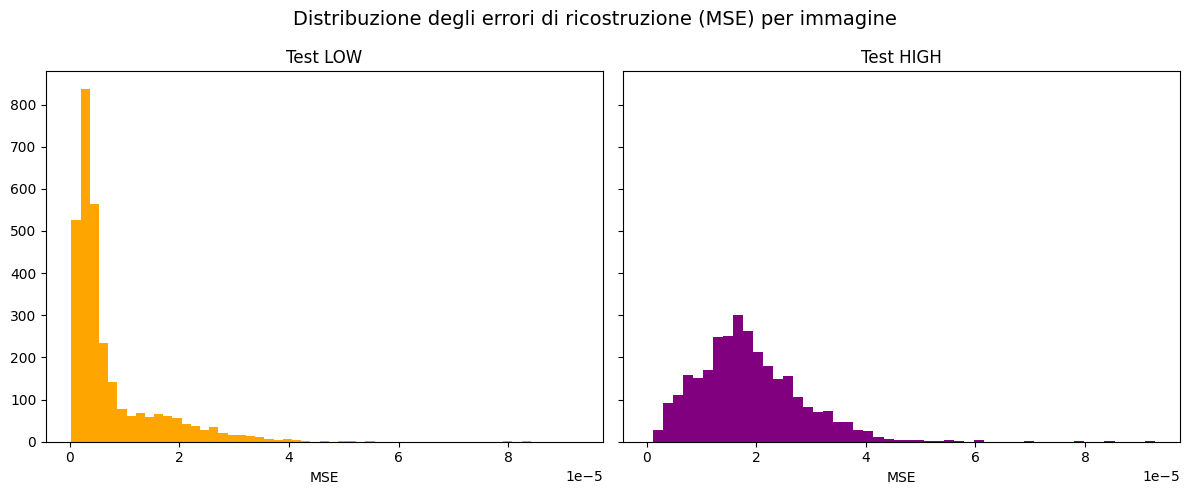


Errore medio di ricostruzione (MSE) sul training set: 0.000004
Errore medio di ricostruzione (MSE) sul test set LOW: 0.000007
Errore medio di ricostruzione (MSE) sul test set HIGH: 0.000019


In [60]:
#@title Confronto degli errori di ricostruzione: Test LOW, Test HIGH

def compute_reconstruction_errors(model, dataloader):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(model.device)
            x_hat = model(x)
            mse = F.mse_loss(x_hat, x, reduction='none')
            mse_per_image = mse.view(mse.size(0), -1).mean(dim=1)
            errors.extend(mse_per_image.cpu().numpy())
    return np.array(errors)

# Calcolo errori
train_errors = compute_reconstruction_errors(model_S, train_loader)
test_errors_l = compute_reconstruction_errors(model_S, test_loader_l)
test_errors_h = compute_reconstruction_errors(model_S, test_loader_h)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

axs[0].hist(test_errors_l, bins=50, color='orange')
axs[0].set_title("Test LOW")
axs[0].set_xlabel("MSE")

axs[1].hist(test_errors_h, bins=50, color='purple')
axs[1].set_title("Test HIGH")
axs[1].set_xlabel("MSE")

plt.suptitle("Distribuzione degli errori di ricostruzione (MSE) per immagine", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nErrore medio di ricostruzione (MSE) sul training set: {train_errors.mean():.6f}")
print(f"Errore medio di ricostruzione (MSE) sul test set LOW: {test_errors_l.mean():.6f}")
print(f"Errore medio di ricostruzione (MSE) sul test set HIGH: {test_errors_h.mean():.6f}")

In [59]:
#@title Plot interattivo 3D: Train+Val, Test LOW, Test HIGH con Plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def extract_latents(dataloader, model):
    latents = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(model.device)
            z = model.encoder_fc(model.encoder_conv(x))
            latents.append(z.cpu().numpy())
    return np.concatenate(latents, axis=0)

# Estrazione
latents_train = extract_latents(train_loader, model_S)
latents_low = extract_latents(test_loader_l, model_S)
latents_high = extract_latents(test_loader_h, model_S)

# Funzione per creare uno scatter3D Plotly
def plot_latents_plotly(latents, name, color):
    return go.Scatter3d(
        x=latents[:, 0], y=latents[:, 1], z=latents[:, 2],
        mode='markers',
        marker=dict(size=2, color=color, opacity=0.6),
        name=name
    )

# Subplots Plotly
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}]*3],
    subplot_titles=["Train", "Test LOW", "Test HIGH"]
)

# Tracce
fig.add_trace(plot_latents_plotly(latents_train, "Train", "deepskyblue"), row=1, col=1)
fig.add_trace(plot_latents_plotly(latents_low, "Test LOW", "orange"), row=1, col=2)
fig.add_trace(plot_latents_plotly(latents_high, "Test HIGH", "purple"), row=1, col=3)

# Layout
fig.update_layout(
    height=600, width=1800,
    title_text="Confronto Spazio Latente - Train+Val vs Test",
    showlegend=True
)

fig.show()


### Modello L -> 32D

In [62]:
model_L = ConvAE(params_L).to(DEVICE)

# Supponendo input (1, 100, 100)
summary(model_L, input_size=(1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 50, 50]             272
              ReLU-2           [-1, 16, 50, 50]               0
         Dropout2d-3           [-1, 16, 50, 50]               0
            Conv2d-4           [-1, 32, 25, 25]           8,224
              ReLU-5           [-1, 32, 25, 25]               0
         Dropout2d-6           [-1, 32, 25, 25]               0
            Conv2d-7           [-1, 64, 12, 12]          32,832
              ReLU-8           [-1, 64, 12, 12]               0
         Dropout2d-9           [-1, 64, 12, 12]               0
          Flatten-10                 [-1, 9216]               0
           Linear-11                   [-1, 32]         294,944
           Linear-12                 [-1, 9216]         304,128
             ReLU-13                 [-1, 9216]               0
  ConvTranspose2d-14           [-1, 32,

In [38]:
#@title Training del modello Medium

# Inizializza il modello
model_L = ConvAE(params_L)

early_stop_cb = EarlyStopping(
    monitor="train_loss",
    patience=PATIENCE,
    mode="min"
)

# Trainer
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto",
    callbacks=[early_stop_cb],
    log_every_n_steps=10
)

# Training
trainer.fit(model_L, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | encoder_conv | Sequential | 41.3 K | train
1 | encoder_fc   | Sequential | 294 K  | train
2 | decoder_fc   | Sequential | 304 K  | train
3 | decoder_conv | Sequential | 41.3 K | train
----------------------------------------------------
681 K     Trainable params
0         Non-trainable params
681 K     Total params
2.727     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]